## 1. Instalação e Imports

In [18]:
# Instalação de dependências
%pip install tensorflow opencv-python pillow requests numpy matplotlib scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
import json
import requests
import numpy as np
import cv2
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
from concurrent.futures import ThreadPoolExecutor
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponível: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponível: []


## 2. Configurações

In [20]:
# Configurações do projeto
BASE_DIR = Path(".").resolve()
DATASET_DIR = BASE_DIR / "dataset"
SYNTHETIC_DIR = DATASET_DIR / "synthetic_sketches"
POKEAPI_DIR = DATASET_DIR / "pokeapi_sketches"
COMBINED_DIR = DATASET_DIR / "combined"
MODEL_DIR = BASE_DIR.parent / "model"

# Criar diretórios
POKEAPI_DIR.mkdir(parents=True, exist_ok=True)
COMBINED_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Parâmetros do modelo - AJUSTADOS
IMG_SIZE = 224  # MobileNetV2 usa 224x224
BATCH_SIZE = 16  # Menor para melhor generalização
EPOCHS = 100  # Mais épocas, early stopping vai parar quando necessário

print(f"Dataset dir: {DATASET_DIR}")
print(f"Model dir: {MODEL_DIR}")

Dataset dir: C:\trabalho\poke_guess\notebooks\dataset
Model dir: C:\trabalho\poke_guess\model


## 3. Download de Imagens da PokeAPI e Conversão para Sketch

In [21]:
def get_pokemon_sprites(pokemon_name, pokemon_id):
    """Obtém URLs de sprites de um Pokemon da PokeAPI."""
    urls = []
    base_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon"
    
    # Sprites normais
    urls.append(f"{base_url}/{pokemon_id}.png")
    urls.append(f"{base_url}/back/{pokemon_id}.png")
    
    # Sprites shiny
    urls.append(f"{base_url}/shiny/{pokemon_id}.png")
    urls.append(f"{base_url}/shiny/back/{pokemon_id}.png")
    
    # Artwork oficial
    urls.append(f"{base_url}/other/official-artwork/{pokemon_id}.png")
    
    return urls


def image_to_sketch(image, method='canny'):
    """Converte uma imagem para sketch estilo desenho."""
    # Converter para array numpy
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Se tem canal alpha, usar como máscara
    if image.shape[-1] == 4:
        alpha = image[:, :, 3]
        rgb = image[:, :, :3]
    else:
        alpha = None
        rgb = image
    
    # Converter para grayscale
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    if method == 'canny':
        # Aplicar blur para reduzir ruído
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        # Detecção de bordas
        edges = cv2.Canny(blurred, 30, 100)
        # Inverter para ter linhas pretas em fundo branco
        sketch = 255 - edges
    elif method == 'pencil':
        # Inverter
        inv = 255 - gray
        # Blur
        blur = cv2.GaussianBlur(inv, (21, 21), 0)
        # Dividir
        sketch = cv2.divide(gray, 255 - blur, scale=256)
    else:
        # Laplacian
        lap = cv2.Laplacian(gray, cv2.CV_64F)
        sketch = 255 - np.uint8(np.absolute(lap))
    
    # Aplicar máscara alpha se existir
    if alpha is not None:
        mask = alpha > 10
        result = np.ones_like(sketch) * 255
        result[mask] = sketch[mask]
        sketch = result
    
    return sketch


def download_and_convert_sprite(args):
    """Download e converte um sprite para sketch."""
    url, pokemon_name, output_dir, idx, method = args
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content)).convert('RGBA')
            # Redimensionar para tamanho maior antes de converter
            img = img.resize((256, 256), Image.Resampling.LANCZOS)
            
            sketch = image_to_sketch(img, method=method)
            
            # Salvar
            output_path = output_dir / f"{method}_{idx}.png"
            cv2.imwrite(str(output_path), sketch)
            return True
    except Exception as e:
        pass
    return False


# Listar Pokemon existentes em synthetic_sketches
existing_pokemon = [d.name for d in SYNTHETIC_DIR.iterdir() if d.is_dir()]
print(f"Pokemon existentes: {len(existing_pokemon)}")
print(existing_pokemon[:10], "...")

Pokemon existentes: 251
['abra', 'aerodactyl', 'aipom', 'alakazam', 'ampharos', 'arbok', 'arcanine', 'ariados', 'articuno', 'azumarill'] ...


In [22]:
# Baixar sprites da PokeAPI para cada Pokemon
print("Baixando e convertendo sprites da PokeAPI...")

# Mapeamento nome -> ID (1ª e 2ª geração = 1-251)
pokemon_ids = {}
response = requests.get("https://pokeapi.co/api/v2/pokemon?limit=251")
if response.status_code == 200:
    data = response.json()
    for pokemon in data['results']:
        pokemon_id = int(pokemon['url'].split('/')[-2])
        pokemon_ids[pokemon['name']] = pokemon_id

print(f"IDs carregados: {len(pokemon_ids)}")

# Baixar para cada Pokemon existente
methods = ['canny', 'pencil', 'laplacian']
download_tasks = []

for pokemon_name in existing_pokemon:
    # Normalizar nome
    api_name = pokemon_name.replace('-', '-').lower()
    
    if api_name in pokemon_ids:
        pokemon_id = pokemon_ids[api_name]
        output_dir = POKEAPI_DIR / pokemon_name
        output_dir.mkdir(parents=True, exist_ok=True)
        
        urls = get_pokemon_sprites(pokemon_name, pokemon_id)
        
        for idx, url in enumerate(urls):
            for method in methods:
                task_idx = idx * len(methods) + methods.index(method)
                download_tasks.append((url, pokemon_name, output_dir, task_idx, method))

print(f"Total de tarefas de download: {len(download_tasks)}")

# Executar downloads em paralelo
successful = 0
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(download_and_convert_sprite, download_tasks))
    successful = sum(results)

print(f"Downloads bem-sucedidos: {successful}/{len(download_tasks)}")

Baixando e convertendo sprites da PokeAPI...
IDs carregados: 251
Total de tarefas de download: 3765
Downloads bem-sucedidos: 3012/3765


## 4. Combinar Datasets

In [23]:
def combine_datasets():
    """Combina synthetic_sketches e pokeapi_sketches em um único dataset."""
    print("Combinando datasets...")
    
    total_copied = 0
    
    for pokemon_name in existing_pokemon:
        output_dir = COMBINED_DIR / pokemon_name
        output_dir.mkdir(parents=True, exist_ok=True)
        
        img_count = 0
        
        # Copiar de synthetic_sketches
        synthetic_path = SYNTHETIC_DIR / pokemon_name
        if synthetic_path.exists():
            for img_file in synthetic_path.glob("*.png"):
                dest = output_dir / f"syn_{img_count}.png"
                shutil.copy2(img_file, dest)
                img_count += 1
        
        # Copiar de pokeapi_sketches
        pokeapi_path = POKEAPI_DIR / pokemon_name
        if pokeapi_path.exists():
            for img_file in pokeapi_path.glob("*.png"):
                dest = output_dir / f"api_{img_count}.png"
                shutil.copy2(img_file, dest)
                img_count += 1
        
        total_copied += img_count
    
    print(f"Total de imagens combinadas: {total_copied}")
    return total_copied

combine_datasets()

Combinando datasets...
Total de imagens combinadas: 5271


5271

Total de classes: 251
Total de imagens: 5271
Média por classe: 21.0
Mínimo por classe: 21
Máximo por classe: 21


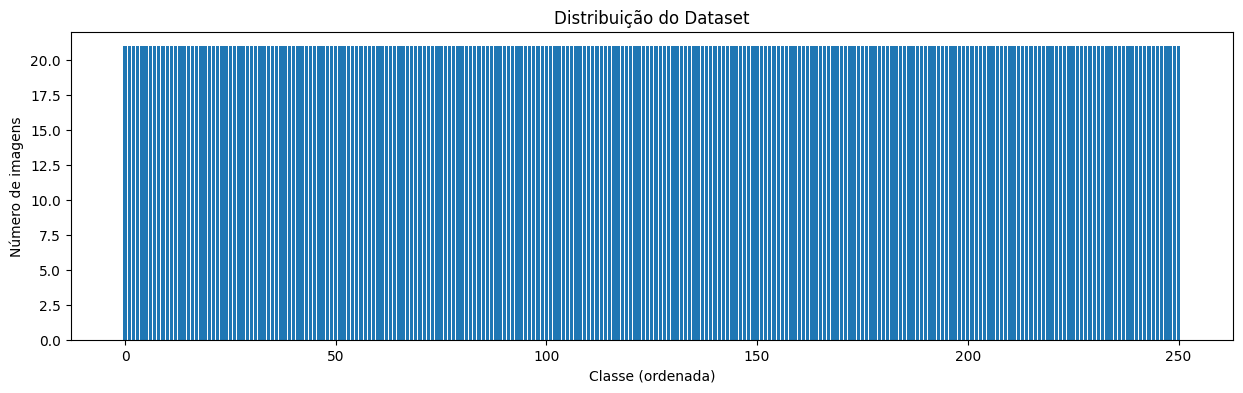

In [24]:
# Verificar distribuição do dataset
class_counts = {}
for pokemon_dir in COMBINED_DIR.iterdir():
    if pokemon_dir.is_dir():
        count = len(list(pokemon_dir.glob("*.png")))
        class_counts[pokemon_dir.name] = count

print(f"Total de classes: {len(class_counts)}")
print(f"Total de imagens: {sum(class_counts.values())}")
print(f"Média por classe: {np.mean(list(class_counts.values())):.1f}")
print(f"Mínimo por classe: {min(class_counts.values())}")
print(f"Máximo por classe: {max(class_counts.values())}")

# Plot distribuição
plt.figure(figsize=(15, 4))
plt.bar(range(len(class_counts)), sorted(class_counts.values()))
plt.xlabel("Classe (ordenada)")
plt.ylabel("Número de imagens")
plt.title("Distribuição do Dataset")
plt.show()

## 5. Preparação dos Dados com Augmentation

In [25]:
def preprocess_image(image_path, target_size=(IMG_SIZE, IMG_SIZE)):
    """Preprocessa uma imagem para o modelo."""
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    
    # Redimensionar
    img = cv2.resize(img, target_size)
    
    # Converter para RGB (3 canais) para MobileNetV2
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Normalizar para [-1, 1] (padrão MobileNetV2)
    img = img.astype(np.float32) / 127.5 - 1.0
    
    return img


# Carregar dados
print("Carregando imagens...")

images = []
labels = []
label_names = sorted([d.name for d in COMBINED_DIR.iterdir() if d.is_dir()])
label_to_idx = {name: idx for idx, name in enumerate(label_names)}

for pokemon_name in label_names:
    pokemon_dir = COMBINED_DIR / pokemon_name
    for img_path in pokemon_dir.glob("*.png"):
        img = preprocess_image(img_path)
        if img is not None:
            images.append(img)
            labels.append(label_to_idx[pokemon_name])

X = np.array(images)
y = np.array(labels)

print(f"Shape dos dados: {X.shape}")
print(f"Número de classes: {len(label_names)}")
print(f"Imagens por classe (média): {len(X) / len(label_names):.1f}")

# Split em treino/validação/teste - AJUSTADO (menos para teste)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Treino: {X_train.shape[0]} | Validação: {X_val.shape[0]} | Teste: {X_test.shape[0]}")

Carregando imagens...
Shape dos dados: (5271, 224, 224, 3)
Número de classes: 251
Imagens por classe (média): 21.0
Treino: 4216 | Validação: 527 | Teste: 528


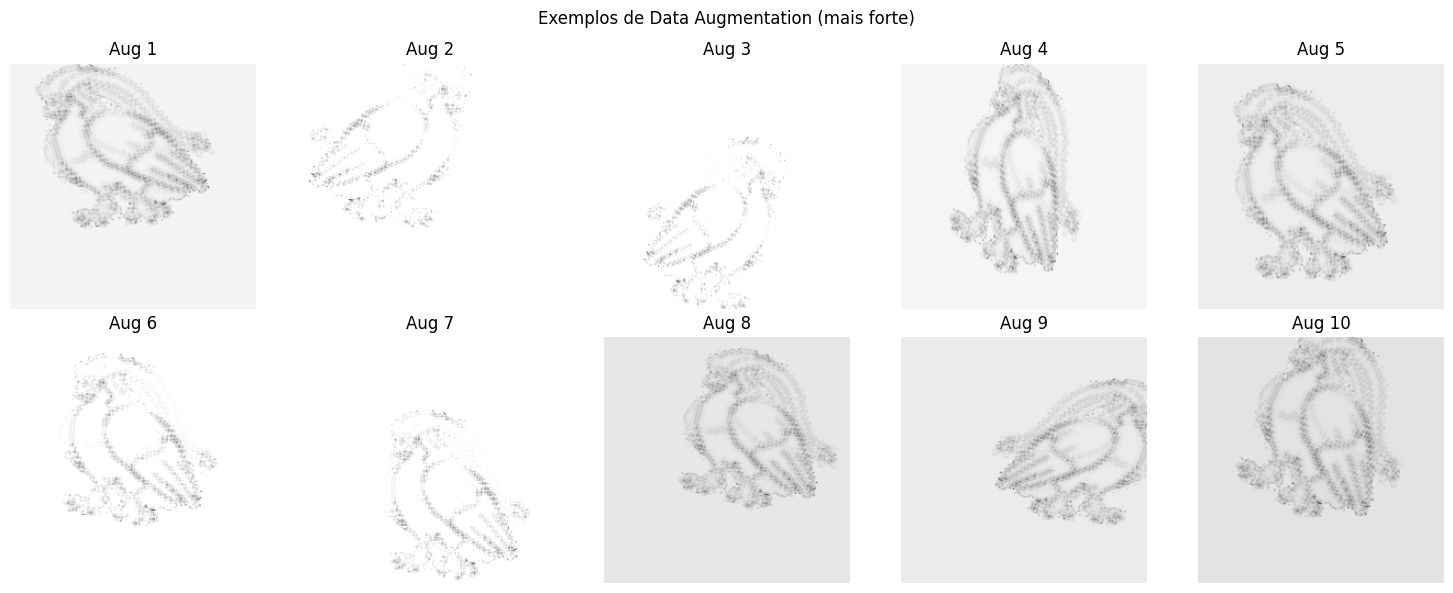

In [26]:
# Data Augmentation MAIS FORTE para compensar poucos dados
train_datagen = ImageDataGenerator(
    rotation_range=30,           # Rotação mais forte
    width_shift_range=0.2,       # Shift horizontal maior
    height_shift_range=0.2,      # Shift vertical maior
    shear_range=0.2,             # Shear mais forte
    zoom_range=0.2,              # Zoom mais forte
    horizontal_flip=True,        # Flip horizontal
    vertical_flip=False,         # Não flip vertical (Pokemon tem orientação)
    brightness_range=[0.8, 1.2], # Variação de brilho
    fill_mode='constant',
    cval=1.0                     # Preencher com branco (fundo do sketch)
)

val_datagen = ImageDataGenerator()  # Sem augmentation para validação

# Criar generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

# Visualizar exemplos de augmentation
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
sample_img = X_train[0:1]
for i, ax in enumerate(axes.flat):
    aug_img = train_datagen.random_transform(sample_img[0])
    # Desnormalizar para visualização
    display_img = (aug_img + 1.0) / 2.0
    ax.imshow(display_img)
    ax.axis('off')
    ax.set_title(f'Aug {i+1}')
plt.suptitle('Exemplos de Data Augmentation (mais forte)')
plt.tight_layout()
plt.show()

## 6. Arquitetura do Modelo (Transfer Learning com MobileNetV2)

Usamos Transfer Learning porque:
- Temos poucos dados (~21 imagens por classe)
- MobileNetV2 já aprendeu features visuais úteis
- Congelamos a base e treinamos apenas o classificador

In [27]:
def create_model(num_classes, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    """Cria modelo com Transfer Learning usando MobileNetV2."""
    
    # Carregar MobileNetV2 pré-treinado (sem a camada de classificação)
    base_model = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    
    # Congelar a base inicialmente
    base_model.trainable = False
    
    # Criar modelo completo
    model = models.Sequential([
        base_model,
        layers.Dense(512, kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(256, kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# Criar modelo
num_classes = len(label_names)
model, base_model = create_model(num_classes)

# Compilar com learning rate menor
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
print(f"\nTotal de parâmetros treináveis: {sum(p.numpy().size for p in model.trainable_weights):,}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 251)            │        64,507 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,112,763 (11.87 MB)

 Trainable params: 853,243 (3.25 MB)

 Non-trainable params: 2,259,520 (8.62 MB)


Total de parâmetros treináveis: 853,243


## 7. Treinamento

In [28]:
# Callbacks AJUSTADOS
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitorar accuracy, não loss
        patience=15,             # Mais paciência
        restore_best_weights=True,
        verbose=1,
        mode='max'               # Queremos maximizar accuracy
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        str(MODEL_DIR / 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

# Fase 1: Treinar apenas o classificador (base congelada)
print("=" * 50)
print("FASE 1: Treinando classificador (base congelada)")
print("=" * 50)

history1 = model.fit(
    train_generator,
    steps_per_epoch=max(1, len(X_train) // BATCH_SIZE),
    epochs=30,
    validation_data=val_generator,
    validation_steps=max(1, len(X_val) // BATCH_SIZE),
    callbacks=callbacks,
    verbose=1
)

FASE 1: Treinando classificador (base congelada)
Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.0110 - loss: 13.6044
Epoch 1: val_accuracy improved from None to 0.14844, saving model to C:\trabalho\poke_guess\model\best_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 43s 151ms/step - accuracy: 0.0233 - loss: 11.5343 - val_accuracy: 0.1484 - val_loss: 7.9589 - learning_rate: 0.0010
Epoch 2/30
  1/263 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.0000e+00 - loss: 8.7863

C:\Users\thiag\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.14844 to 0.15039, saving model to C:\trabalho\poke_guess\model\best_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0000e+00 - loss: 8.7863 - val_accuracy: 0.1504 - val_loss: 7.9476 - learning_rate: 0.0010
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0874 - loss: 7.6795
Epoch 3: val_accuracy improved from 0.15039 to 0.27930, saving model to C:\trabalho\poke_guess\model\best_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 132ms/step - accuracy: 0.0986 - loss: 7.2037 - val_accuracy: 0.2793 - val_loss: 5.7880 - learning_rate: 0.0010
Epoch 4/30
  1/263 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.0625 - loss: 6.2190
Epoch 4: val_accuracy improved from 0.27930 to 0.28906, saving model to C:\trabalho\poke_guess\model\best_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0625 - loss: 6.2190 - val_accuracy: 0.2891 - val_loss: 5.7878 - learning_rate: 0.0010
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━

In [29]:
# Fase 2: Fine-tuning - descongelar parte da base
print("=" * 50)
print("FASE 2: Fine-tuning (descongelando últimas camadas)")
print("=" * 50)

# Descongelar as últimas 30 camadas do MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar com learning rate MUITO menor para fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Parâmetros treináveis após fine-tuning: {sum(p.numpy().size for p in model.trainable_weights):,}")

# Continuar treinamento
history2 = model.fit(
    train_generator,
    steps_per_epoch=max(1, len(X_train) // BATCH_SIZE),
    epochs=50,
    validation_data=val_generator,
    validation_steps=max(1, len(X_val) // BATCH_SIZE),
    callbacks=callbacks,
    verbose=1
)

# Combinar históricos
history = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy']
}

FASE 2: Fine-tuning (descongelando últimas camadas)
Parâmetros treináveis após fine-tuning: 2,379,323
Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2702 - loss: 4.7723
Epoch 1: val_accuracy did not improve from 0.66211
263/263 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.2900 - loss: 4.5689 - val_accuracy: 0.5918 - val_loss: 3.2051 - learning_rate: 1.0000e-05
Epoch 2/50
  1/263 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.1875 - loss: 4.9757
Epoch 2: val_accuracy did not improve from 0.66211
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1875 - loss: 4.9757 - val_accuracy: 0.5840 - val_loss: 3.2243 - learning_rate: 1.0000e-05
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3668 - loss: 4.1823
Epoch 3: val_accuracy did not improve from 0.66211
263/263 ━━━━━━━━━━━━━━━━━━━━ 38s 143ms/step - accuracy: 0.3610 - loss: 4.1904 - val_accuracy: 0.6230 - val_loss: 3.0318 - learning_rate: 1.0000e-05
Epoch 4/50
  1/263 ━━━━━━━━━━━━━━━━━━━━ 

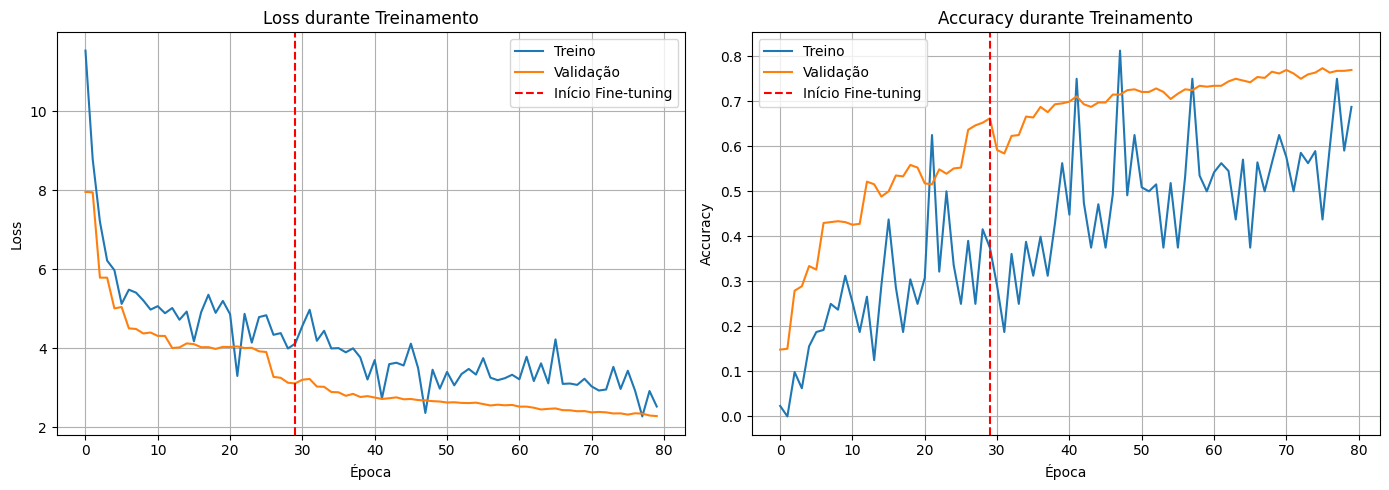


Melhor val_accuracy: 0.7734


In [30]:
# Plot histórico de treinamento completo (Fase 1 + Fase 2)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['loss'], label='Treino')
axes[0].plot(history['val_loss'], label='Validação')
axes[0].axvline(x=len(history1.history['loss'])-1, color='r', linestyle='--', label='Início Fine-tuning')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss durante Treinamento')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['accuracy'], label='Treino')
axes[1].plot(history['val_accuracy'], label='Validação')
axes[1].axvline(x=len(history1.history['accuracy'])-1, color='r', linestyle='--', label='Início Fine-tuning')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy durante Treinamento')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(str(MODEL_DIR / 'training_history.png'), dpi=150)
plt.show()

print(f"\nMelhor val_accuracy: {max(history['val_accuracy']):.4f}")

## 8. Avaliação do Modelo

In [31]:
# Carregar melhor modelo
best_model = keras.models.load_model(str(MODEL_DIR / 'best_model.keras'))

# Avaliar no conjunto de teste
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nResultados no conjunto de teste:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Resultados no conjunto de teste:
Loss: 2.3915
Accuracy: 0.7538 (75.38%)


In [32]:
# Top-k accuracy
def top_k_accuracy(model, X, y, k=5):
    predictions = model.predict(X, verbose=0)
    top_k_preds = np.argsort(predictions, axis=1)[:, -k:]
    correct = sum(1 for i, true_label in enumerate(y) if true_label in top_k_preds[i])
    return correct / len(y)

top1 = top_k_accuracy(best_model, X_test, y_test, k=1)
top3 = top_k_accuracy(best_model, X_test, y_test, k=3)
top5 = top_k_accuracy(best_model, X_test, y_test, k=5)

print(f"Top-1 Accuracy: {top1:.4f} ({top1*100:.2f}%)")
print(f"Top-3 Accuracy: {top3:.4f} ({top3*100:.2f}%)")
print(f"Top-5 Accuracy: {top5:.4f} ({top5*100:.2f}%)")

Top-1 Accuracy: 0.7538 (75.38%)
Top-3 Accuracy: 0.8485 (84.85%)
Top-5 Accuracy: 0.8807 (88.07%)


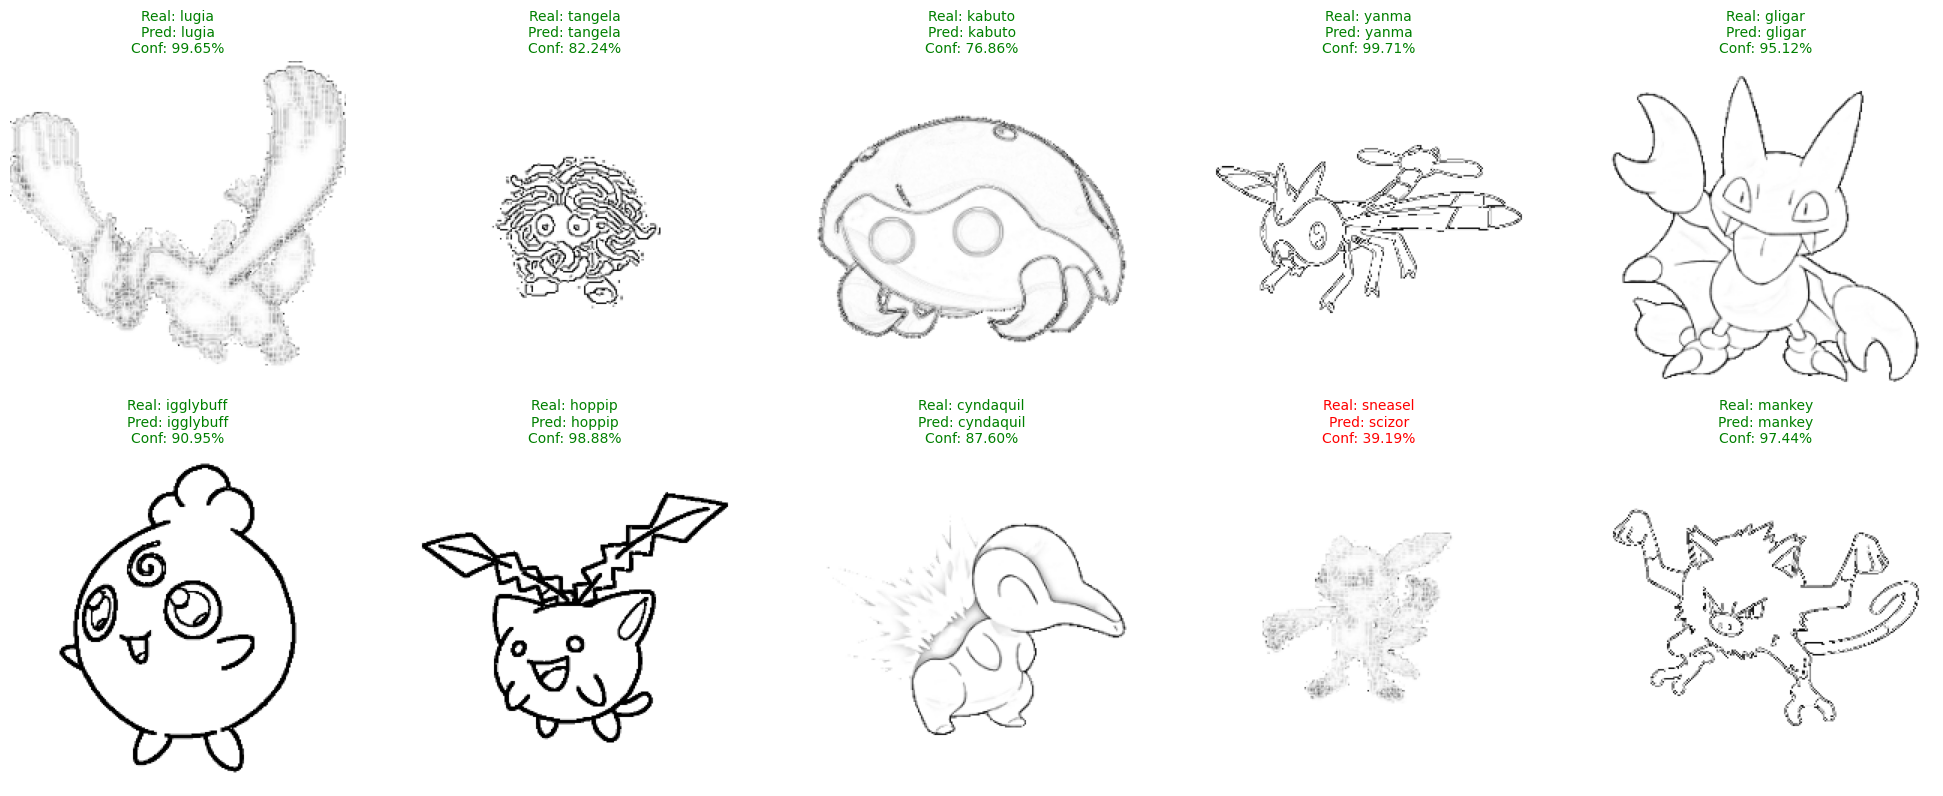

In [33]:
# Visualizar predições
def predict_pokemon(model, image, label_names, top_k=5):
    """Faz predição e retorna top-k resultados com confiança."""
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)
    
    predictions = model.predict(image, verbose=0)[0]
    
    # Top-k índices
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    
    results = []
    for idx in top_indices:
        results.append({
            'name': label_names[idx],
            'confidence': float(predictions[idx])
        })
    
    return results


# Mostrar algumas predições
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
random_indices = np.random.choice(len(X_test), 10, replace=False)

for ax, idx in zip(axes.flat, random_indices):
    img = X_test[idx]
    true_label = label_names[y_test[idx]]
    
    results = predict_pokemon(best_model, img, label_names, top_k=3)
    pred_label = results[0]['name']
    confidence = results[0]['confidence']
    
    # Desnormalizar para visualização
    display_img = (img + 1.0) / 2.0
    ax.imshow(display_img)
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f"Real: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}", 
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 9. Salvar Modelo e Metadados

In [34]:
# Salvar modelo final
model_path = MODEL_DIR / 'pokemon_sketch_classifier.keras'
best_model.save(str(model_path))
print(f"Modelo salvo em: {model_path}")

# Salvar mapeamento de labels
label_map = {
    'idx_to_name': {str(idx): name for idx, name in enumerate(label_names)},
    'name_to_idx': {name: idx for idx, name in enumerate(label_names)},
    'num_classes': len(label_names),
    'img_size': IMG_SIZE,
    'normalization': 'mobilenetv2'  # [-1, 1]
}

label_map_path = MODEL_DIR / 'label_map.json'
with open(label_map_path, 'w') as f:
    json.dump(label_map, f, indent=2)
print(f"Label map salvo em: {label_map_path}")

# Salvar métricas
metrics = {
    'test_loss': float(test_loss),
    'test_accuracy': float(test_accuracy),
    'top1_accuracy': float(top1),
    'top3_accuracy': float(top3),
    'top5_accuracy': float(top5),
    'epochs_trained': len(history['loss']),
    'best_val_accuracy': float(max(history['val_accuracy'])),
    'num_classes': len(label_names),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test)
}

metrics_path = MODEL_DIR / 'metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"Métricas salvas em: {metrics_path}")

print("\n" + "=" * 50)
print("RESUMO DO TREINAMENTO")
print("=" * 50)
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Top-3 Accuracy: {top3:.2%}")
print(f"Top-5 Accuracy: {top5:.2%}")

Modelo salvo em: C:\trabalho\poke_guess\model\pokemon_sketch_classifier.keras
Label map salvo em: C:\trabalho\poke_guess\model\label_map.json
Métricas salvas em: C:\trabalho\poke_guess\model\metrics.json

RESUMO DO TREINAMENTO
Test Accuracy: 75.38%
Top-3 Accuracy: 84.85%
Top-5 Accuracy: 88.07%


## 10. Função de Inferência (para uso no serviço)

In [35]:
class PokemonSketchClassifier:
    """Classe para classificação de sketches de Pokemon."""
    
    def __init__(self, model_path, label_map_path):
        self.model = keras.models.load_model(model_path)
        with open(label_map_path, 'r') as f:
            self.label_map = json.load(f)
        self.img_size = self.label_map.get('img_size', 224)
    
    def preprocess(self, image):
        """Preprocessa imagem para inferência."""
        if isinstance(image, str):
            img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        elif isinstance(image, np.ndarray):
            if len(image.shape) == 3 and image.shape[-1] == 3:
                img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            elif len(image.shape) == 3 and image.shape[-1] == 1:
                img = image.squeeze()
            else:
                img = image
        else:
            raise ValueError("Imagem deve ser path ou numpy array")
        
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = img.astype(np.float32) / 127.5 - 1.0
        img = np.expand_dims(img, axis=0)
        return img
    
    def predict(self, image, top_k=5):
        """Retorna predições com nome e confiança."""
        img = self.preprocess(image)
        predictions = self.model.predict(img, verbose=0)[0]
        
        top_indices = np.argsort(predictions)[-top_k:][::-1]
        
        results = []
        for idx in top_indices:
            name = self.label_map['idx_to_name'][str(idx)]
            confidence = float(predictions[idx])
            results.append({
                'name': name,
                'confidence': confidence,
                'confidence_percent': f"{confidence * 100:.2f}%"
            })
        
        return results


# Teste da classe
classifier = PokemonSketchClassifier(
    str(MODEL_DIR / 'pokemon_sketch_classifier.keras'),
    str(MODEL_DIR / 'label_map.json')
)

# Testar com uma imagem do test set (já normalizada para [-1, 1])
test_img = ((X_test[0] + 1.0) * 127.5).astype(np.uint8)  # Desnormalizar para uint8
results = classifier.predict(test_img)

print("\nExemplo de predição:")
print(f"Label real: {label_names[y_test[0]]}")
print("\nTop-5 predições:")
for i, r in enumerate(results, 1):
    print(f"  {i}. {r['name']}: {r['confidence_percent']}")


Exemplo de predição:
Label real: wooper

Top-5 predições:
  1. wooper: 84.94%
  2. wigglytuff: 2.04%
  3. hoothoot: 1.50%
  4. igglybuff: 1.47%
  5. spearow: 1.46%


## 11. Resumo e Próximos Passos

### Melhorias aplicadas:
1. **Transfer Learning com MobileNetV2** - Aproveita features pré-treinadas
2. **Fine-tuning em 2 fases** - Primeiro treina classificador, depois ajusta a base
3. **Data Augmentation mais forte** - Rotação, zoom, shift, brilho
4. **Hiperparâmetros ajustados** - Mais paciência, learning rate adaptativo
5. **Imagens 224x224 RGB** - Padrão do MobileNetV2

### Arquivos gerados:
- `model/pokemon_sketch_classifier.keras` - Modelo treinado
- `model/best_model.keras` - Melhor checkpoint
- `model/label_map.json` - Mapeamento de labels
- `model/metrics.json` - Métricas de avaliação
- `model/training_history.png` - Gráfico de treinamento

### Para usar no serviço:
```python
from classifier import PokemonSketchClassifier

classifier = PokemonSketchClassifier('model/pokemon_sketch_classifier.keras', 'model/label_map.json')
results = classifier.predict(image)  # Retorna [{'name': 'pikachu', 'confidence': 0.95}, ...]
```

### Se ainda precisar melhorar:
- Adicionar mais dados de sketches reais
- Usar técnicas de few-shot learning
- Experimentar EfficientNet ou ResNet50